In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib
import os

In [ ]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')

GPU is available
Number of available GPUs: 1
GPU 0: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Project/Eye_diseases/dataset'
os.listdir(data_dir)

['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']

In [ ]:
tf.random.set_seed(42)

train_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'training', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

test_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'validation', seed = 1, shuffle = True, batch_size = 16, image_size=(256,256))

Found 4237 files belonging to 4 classes.
Using 3814 files for training.
Found 4237 files belonging to 4 classes.
Using 423 files for validation.


In [ ]:
filenames = pathlib.Path(data_dir)
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

cataract : 1038
diabetic_retinopathy : 1108
glaucoma : 1017
normal : 1074


In [ ]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(239, 27)

In [ ]:
train_set = train_data.take(212)
val_set = train_data.skip(212)

In [ ]:
train_set.cardinality().numpy(), val_set.cardinality().numpy()

(212, 27)

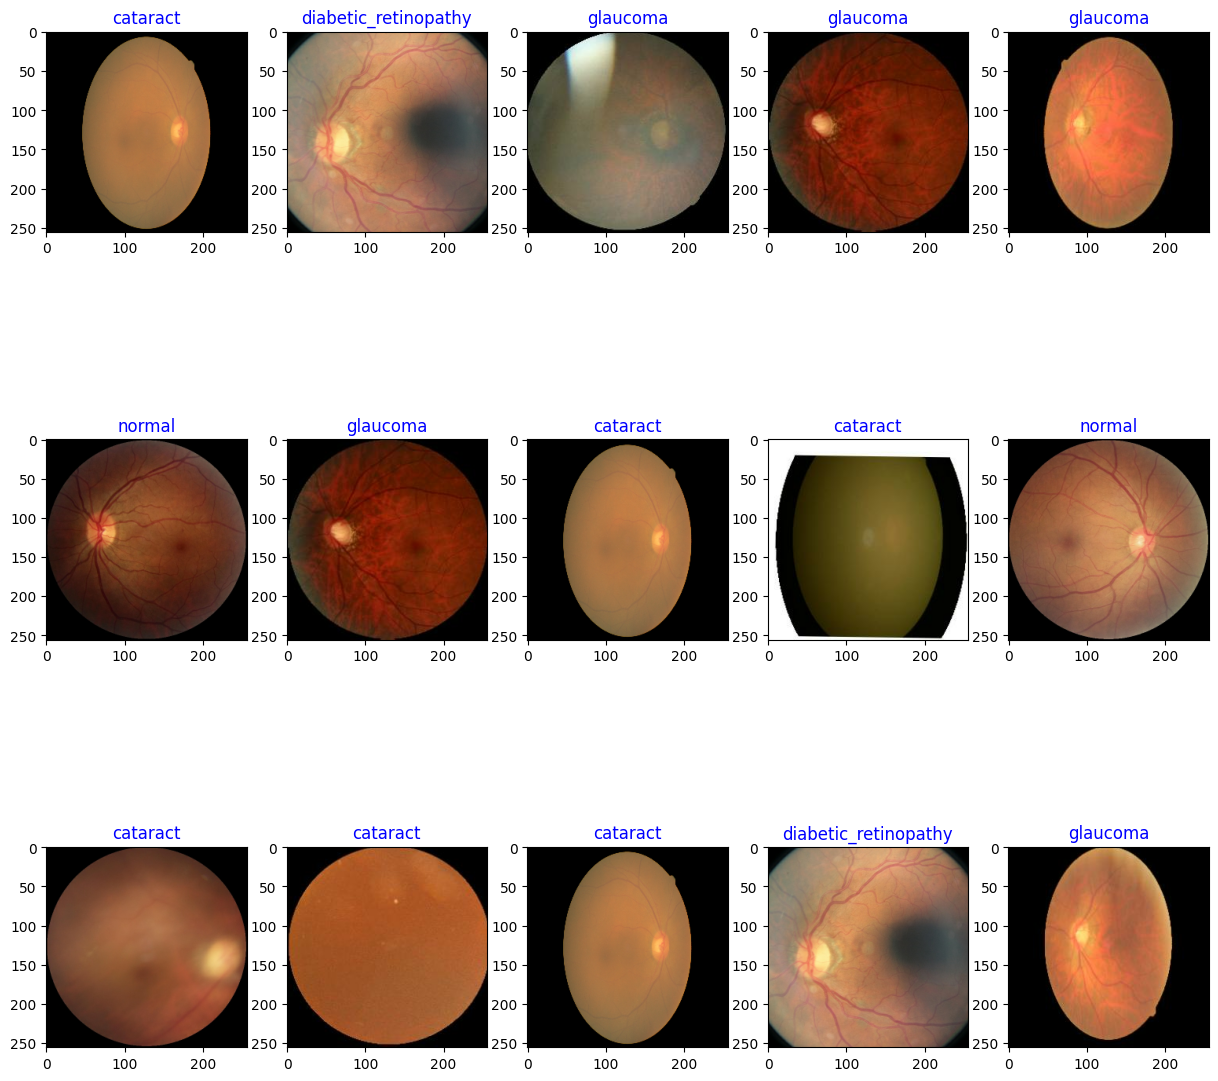

In [ ]:
# print random images from the train set
plt.figure(figsize = (15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color= 'blue', fontsize= 12)
        plt.axis(True)
plt.show()

In [ ]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


**VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
vgg16Model = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg16Model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vgg16Model.trainable = True

In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    vgg16Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 451ms/step - accuracy: 0.5561 - loss: 1.0391 - val_accuracy: 0.8673 - val_loss: 0.3310
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 350ms/step - accuracy: 0.8519 - loss: 0.3880 - val_accuracy: 0.9005 - val_loss: 0.2807
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 350ms/step - accuracy: 0.8953 - loss: 0.2853 - val_accuracy: 0.8815 - val_loss: 0.2859
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 349ms/step - accuracy: 0.9087 - loss: 0.2503 - val_accuracy: 0.8720 - val_loss: 0.2936
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 348ms/step - accuracy: 0.9214 - loss: 0.2095 - val_accuracy: 0.9100 - val_loss: 0.2203
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 349ms/step - accuracy: 0.9399 - loss: 0.1708 - val_accuracy: 0.9100 - val_loss: 0.2257
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 349ms/step - accuracy: 0.9438 - loss: 0.1487 - val_accuracy: 0.9147 - val_loss: 0.2232
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 349ms/step - accuracy: 0.9612 - loss: 

In [ ]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

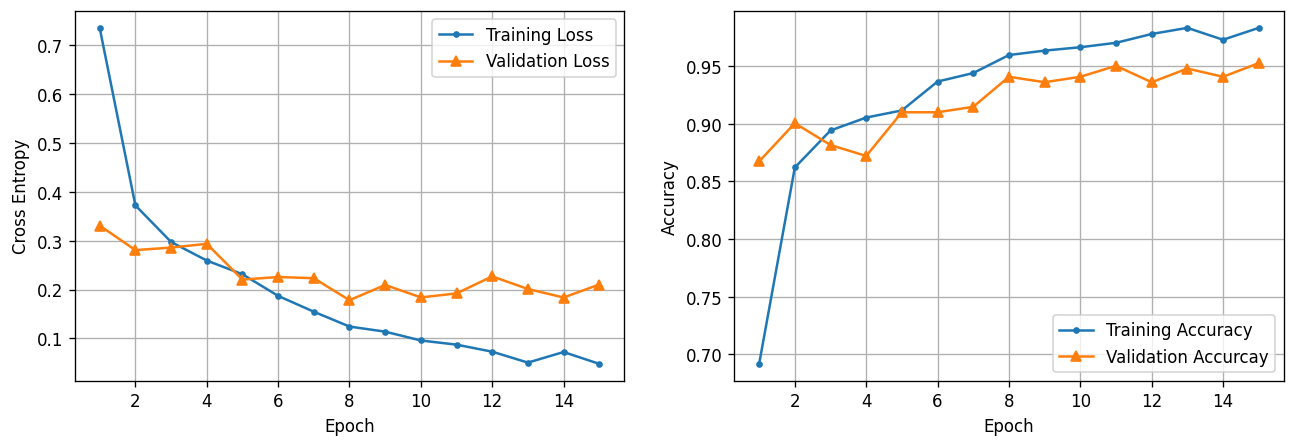

In [ ]:
plot_training_curves(pd.DataFrame(history_2.history))

In [ ]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)

X_test.shape, y_test.shape

(TensorShape([423, 256, 256, 3]), TensorShape([423]))

In [ ]:
from sklearn import metrics

In [ ]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 806ms/step


In [ ]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9462 - loss: 0.2092
Test Loss:  0.21645180881023407
Test Accuracy:  0.9408983588218689


In [ ]:
from sklearn.metrics import classification_report
target_names = ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
print(classification_report(y_test , y_pred, target_names=target_names))

                      precision    recall  f1-score   support

              normal       0.93      0.98      0.96        99
            glaucoma       1.00      1.00      1.00       115
diabetic_retinopathy       0.93      0.87      0.90       102
            cataract       0.90      0.91      0.90       107

            accuracy                           0.94       423
           macro avg       0.94      0.94      0.94       423
        weighted avg       0.94      0.94      0.94       423



**ResNet50V2**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
resNet50V2Model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resNet50V2Model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
resNet50V2Model.trainable = True

In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    resNet50V2Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 114s 249ms/step - accuracy: 0.5501 - loss: 1.3515 - val_accuracy: 0.8412 - val_loss: 0.4314
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.8593 - loss: 0.3913 - val_accuracy: 0.8886 - val_loss: 0.2638
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.9036 - loss: 0.2528 - val_accuracy: 0.8768 - val_loss: 0.2657
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - accuracy: 0.9402 - loss: 0.1805 - val_accuracy: 0.9289 - val_loss: 0.2125
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - accuracy: 0.9571 - loss: 0.1199 - val_accuracy: 0.9360 - val_loss: 0.1764
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.9635 - loss: 0.1069 - val_accuracy: 0.9455 - val_loss: 0.1768
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.9789 - loss: 0.0615 - val_accuracy: 0.9408 - val_loss: 0.1664
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - accuracy: 0.9772 - loss: 

In [ ]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

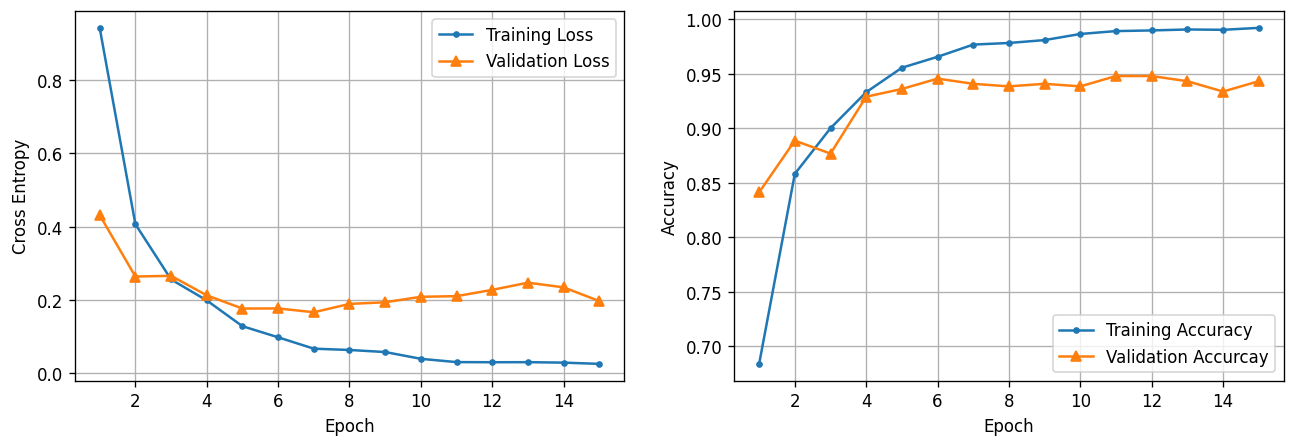

In [ ]:
plot_training_curves(pd.DataFrame(history_2.history))

In [ ]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)

X_test.shape, y_test.shape

(TensorShape([423, 256, 256, 3]), TensorShape([423]))

In [ ]:
from sklearn import metrics

In [ ]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step


In [ ]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9219 - loss: 0.2866
Test Loss:  0.23226936161518097
Test Accuracy:  0.9290780425071716


In [ ]:
from sklearn.metrics import classification_report
target_names = ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
print(classification_report(y_test , y_pred, target_names=target_names))

                      precision    recall  f1-score   support

              normal       0.90      0.96      0.93        99
            glaucoma       1.00      1.00      1.00       115
diabetic_retinopathy       0.91      0.84      0.87       102
            cataract       0.90      0.91      0.90       107

            accuracy                           0.93       423
           macro avg       0.93      0.93      0.93       423
        weighted avg       0.93      0.93      0.93       423

